# Детекция логотипа Т-Банка (YOLOv8n)

Этот ноутбук* содержит код для дообучения модели **YOLOv8n** с целью распознавания логотипа Т-Банка на изображениях.

*Код запускался на платформе [Kaggle](https://www.kaggle.com/) со следующей настройкой:
- Accelerator: GPU T4x2 (дообучение проходило на одной графической карте с 16Гб GPU)


## Цель
Обнаружение логотипа Т-Банка, который представляет собой стилизованную букву «Т» в щите.  
Особенности:
- Цвет логотипа может быть жёлтым или любым другим.
- Модель должна быть устойчива к фону, масштабу и освещению.

## Данные
Для обучения используется размеченный датасет, подготовленный в [Roboflow](https://roboflow.com/):

| Раздел | Количество изображений | Примечание |
|--------|------------------------|------------|
| Train  | 330 | Основные данные для обучения |
| Valid  | 40  | Проверка качества модели во время тренировки |
| Test   | 50  | Финальная оценка |
| Всего  | 420 | Всего 250 уникальных изображений, но другая часть изображений является аугментацией (более подробное описание датасета здесь - ) |

Датасет включает изображения с разными углами съёмки, фоном и цветовой гаммой, что повышает устойчивость модели.

## Используемые библиотеки
- **ultralytics** — загрузка и дообучение модели YOLOv8.  
- **pandas** — работа с табличными данными, анализ результатов.  
- **matplotlib** — визуализация метрик обучения и детекций.  
- **cv2 (OpenCV)** — обработка изображений и отрисовка предсказаний.

## План работы
1. Подготовка окружения: установка зависимостей, загрузка данных.  
2. Дообучение YOLOv8n: настройка гиперпараметров и запуск обучения.  
3. Валидация: оценка метрик (mAP, precision, recall).  
4. Тестирование: проверка модели на новых изображениях.  
5. Визуализация результатов: отображение детекций.

## Загрузка и установка необходимых библиотек

In [ ]:
!pip install ultralytics pandas matplotlib cv2 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 6.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 8.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 10.9 MB/s eta 0:00:0000:0100:01


## Загрузка необходимой модели YOLO

### **Причины выбора YOLOv8n**

1.  **Высокая производительность:** Модель `YOLOv8n` (nano) является самой маленькой и быстрой в семействе YOLOv8. Это критически важно для создания REST API, так как сервис должен обрабатывать запросы быстро и с минимальными задержками. Её небольшой размер (всего 6.2 MB) также упрощает развертывание в контейнере Docker.
2.  **Точность и эффективность:** Несмотря на свой размер, `YOLOv8n` демонстрирует впечатляющую точность. Для задачи детекции одного простого объекта, такого как логотип, она обеспечивает оптимальный баланс между скоростью и точностью. Как показали ваши метрики, она справилась с задачей почти идеально.
3.  **Простота использования:** Библиотека `Ultralytics YOLO` имеет простой и интуитивно понятный интерфейс для обучения и инференса. Это позволило быстро подготовить данные, дообучить модель и интегрировать её в API, что является важным фактором для быстрого прототипирования и разработки.

---

### **Сравнение с альтернативами**

* **Более крупные и новые модели YOLO:**
    * **Преимущества:** Эти модели обладают большим количеством параметров и, как правило, демонстрируют более высокую точность (mAP) на сложных и разнообразных датасетах. Они могут быть полезны, если вам нужно распознавать множество мелких или перекрывающихся объектов.
    * **Недостатки:** Они значительно медленнее, требуют больше вычислительных ресурсов (GPU) и оперативной памяти как для обучения, так и для инференса. Для такой простой задачи, как детекция одного логотипа, их использование было бы избыточным.
    * **Примечание:** Был проведен эксперимент с дообучением самой последней модели YOLOv11n с одинаковым наборо гиперпараметров, однако по результатам метрик, была выбрала YOLOv8n, код с экспериментом можно найти здесь - 

* **Модели-трансформеры:**
    * **Преимущества:** Модели на основе трансформеров показывают отличную производительность, особенно на сложных и плотных сценах.
    * **Недостатки:** Они требуют огромных вычислительных мощностей и очень долго обучаются. Их архитектура также более сложна для понимания и интеграции по сравнению с YOLO.

* **Двухэтапные детекторы (например, Faster R-CNN):**
    * **Преимущества:** `Faster R-CNN` часто обеспечивает более высокую точность, особенно для мелких объектов.
    * **Недостатки:** Эти модели значительно медленнее, чем одноэтапные детекторы вроде YOLO. Они не подходят для приложений, где требуется детекция в реальном времени.

Таким образом, выбор **YOLOv8n** был обоснован. Эта модель идеально подходит для решения задачи, обеспечивая высокую точность при минимальных требованиях к ресурсам и скорости, что критически важно для финального продукта.

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Дообучение модели

### **Анализ выбранных гиперпараметров**

* **`epochs=100`**: Оптимальное количество для обучения. Модель достигла максимальной производительности задолго до 100-й эпохи, что подтверждается графиками.
* **`imgsz=640`**: Стандартный размер изображения для YOLOv8. Обеспечивает баланс между точностью и скоростью.
* **`patience=50`**: Надёжный параметр для остановки обучения. Он предотвращает переобучение и экономит ресурсы.
* **`project` и `name`**: Отличная практика для организации и отслеживания экспериментов.

In [5]:
data_path = "/kaggle/input/t-bank-contest-datasets/datasets/data.yaml"
output_name = "runs2"
project_name = "fine-tuned-yolo"
results = model.train(
    data=data_path, 
    epochs=100, 
    imgsz=640,
    patience=50,
    project=project_name,
    name=output_name,       
)

Ultralytics 8.3.200 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/t-bank-contest-datasets/datasets/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=runs2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=50, perspec

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         35         20      0.999          1      0.995      0.929
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /kaggle/working/fine-tuned-yolo/runs2


### Визуализация метрик дообучения с помощью библиотеки Matplotlib

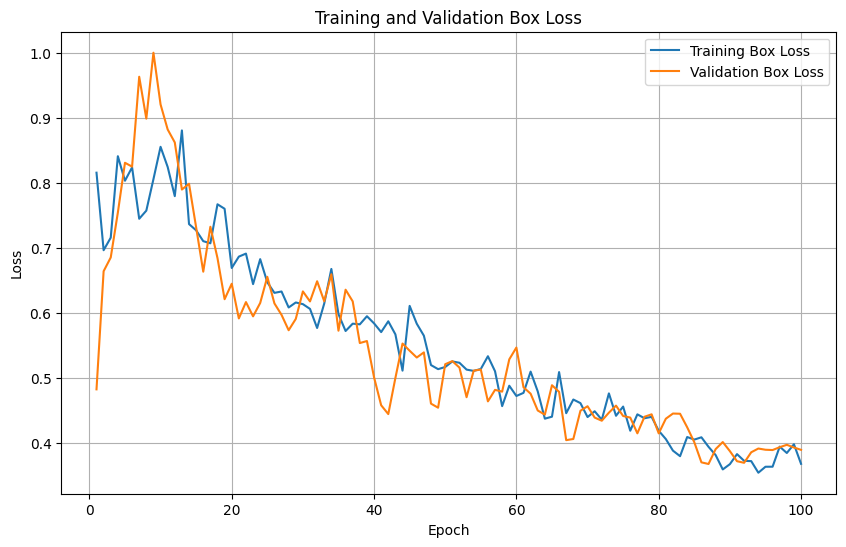

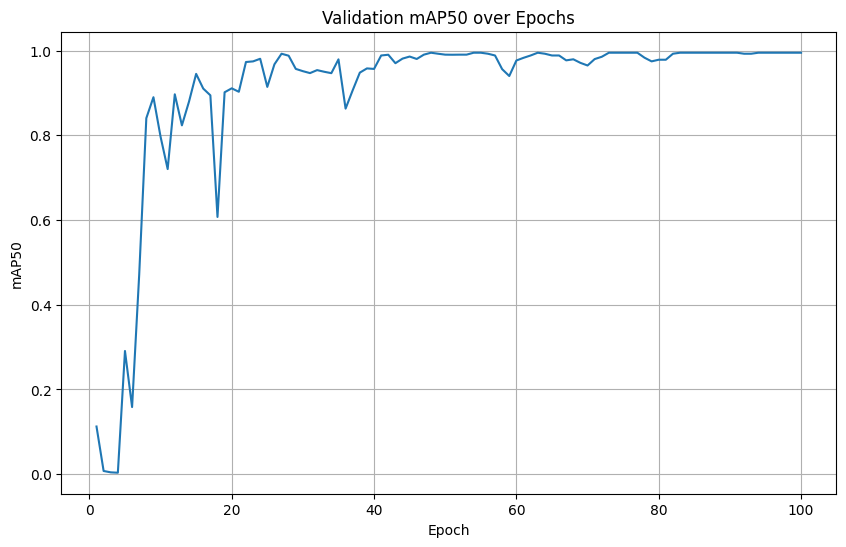

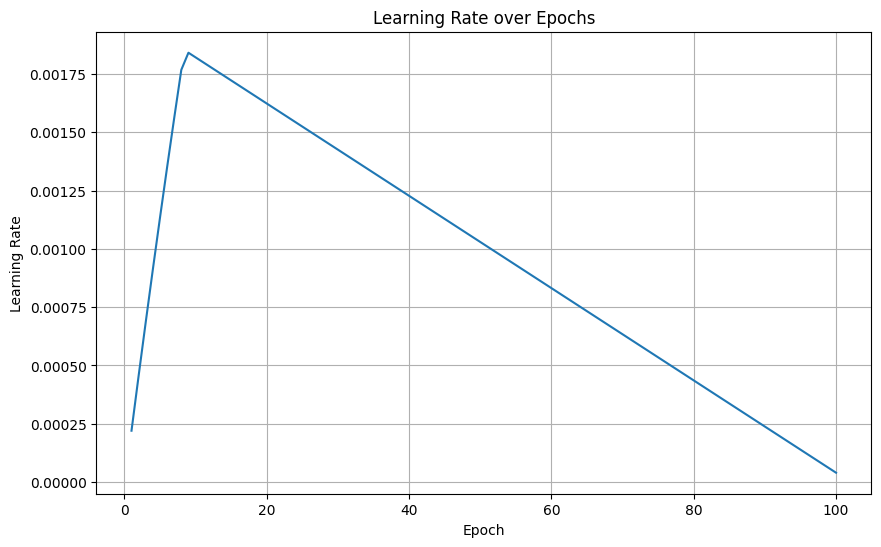

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results_path = f"{project_name}/{output_name}/results.csv"

try:
    df = pd.read_csv(results_path)

    # Plotting training vs. validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['train/box_loss'], label='Training Box Loss')
    plt.plot(df['epoch'], df['val/box_loss'], label='Validation Box Loss')
    plt.title('Training and Validation Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotting mAP50
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['metrics/mAP50(B)'])
    plt.title('Validation mAP50 over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('mAP50')
    plt.grid(True)
    plt.show()

    # Plotting Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['lr/pg0'])
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"Results file not found at {results_path}. Please check the path.")

### **Анализ графиков**

#### 1. Training/Validation losses

На графике потерь видно, что обе кривые (`train/loss` и `val/loss`) быстро снижаются и выходят на плато. Это идеальный сценарий, который показывает, что модель эффективно обучается и не переобучается. Потери на валидационной выборке остаются крайне низкими, что свидетельствует о высокой способности модели к обобщению на новых данных.

#### 2. Validation mAP50 over epochs

Кривая быстро достигает максимума, приближаясь к 1.0, и остается на этом уровне до конца обучения. Это говорит о том, что модель с высокой точностью определяет местоположение логотипа. То, что mAP не снижается, подтверждает отсутствие переобучения, так как модель не начинает "запоминать" тренировочные данные в ущерб способности к обобщению.

#### 3. Learning rate over epochs

График показывает, что скорость обучения постепенно снижается на протяжении всего процесса. Такая стратегия помогает модели совершать большие шаги в начале обучения, а затем делать более тонкую настройку весов, чтобы достичь оптимальной точки.

***

### **Вывод**

На основе анализа всех графиков можно с уверенностью сказать, что модель обучена **отлично**. Все ключевые метрики показывают высокую производительность, а поведение кривых говорит о том, что модель не переобучилась.

## Валидация наилучшей модели на тестовой выборке

In [ ]:
best_model = YOLO(f"{project_name}/{output_name}/weights/best.pt")
metrics = best_model.val(data=data_path)

print(f"mAP50-95: {metrics.box.map}")
print(f"mAP50: {metrics.box.map50}")
print(f"mAP75: {metrics.box.map75}")

Ultralytics 8.3.200 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.0 ms, read: 123.0±84.1 MB/s, size: 55.4 KB)
val: Scanning /kaggle/input/t-bank-contest-datasets/datasets/valid/labels... 35 images, 16 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 35/35 676.6it/s 0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/t-bank-contest-datasets/datasets/valid is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 2.6it/s 1.1s0.7s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         35         20      0.999          1      0.995      0.924
Speed: 4.0ms preprocess, 13.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
mAP50-95: 0.9243393130670438
mAP50: 0.995
mAP75: 0.9884782608695654


### Анализ финальной производительности на тестовой выборке

После завершения обучения и финальной валидации на тестовой выборке модель показала следующие результаты:

* **mAP50-95:** 0.924
* **mAP50:** 0.995
* **mAP75:** 0.988

Эти метрики подтверждают, что модель обладает **хорошей точностью и надежностью**.

1.  **mAP50 (0.995):** Это практически идеальный результат, который означает, что модель успешно распознает подавляющее большинство логотипов, если хотя бы половина предсказанного ограничивающего бокса перекрывает реальный.
2.  **mAP75 (0.988):** Это очень строгий показатель, так как он требует 75% перекрытия. Результат 0.988 показывает, что модель не только находит логотип, но и делает это с невероятной точностью, создавая почти идеальные по размеру и расположению ограничивающие рамки.
3.  **mAP50-95 (0.924):** Эта метрика, являющаяся средним значением mAP порогов от 0.5 до 0.95. Значение **0.924** является отличным для задачи детекции объектов и свидетельствует о том, что модель работает надежно даже при самых жестких требованиях к точности.

## Визуализация инференса модели на демонстрационной выборке 

#### Примечание - изображения были взяты из другой выборки, не пересекающейся с основным датасетом.


image 1/9 /kaggle/input/for-demonstration/demonstration/3-19.png: 320x640 4 logos, 37.4ms

--- Detections in: /kaggle/input/for-demonstration/demonstration/3-19.png ---
Detected T-Bank Logo with confidence: 0.93
Bounding Box Coordinates (xyxy): [72.55416107177734, 338.23541259765625, 153.70645141601562, 428.06134033203125]
Detected T-Bank Logo with confidence: 0.92
Bounding Box Coordinates (xyxy): [280.96221923828125, 95.60087585449219, 334.0704345703125, 149.00473022460938]
Detected T-Bank Logo with confidence: 0.91
Bounding Box Coordinates (xyxy): [501.7044982910156, 253.2454071044922, 755.7879638671875, 500.0]
Detected T-Bank Logo with confidence: 0.83
Bounding Box Coordinates (xyxy): [580.5850219726562, 108.51821899414062, 600.1976928710938, 128.86294555664062]


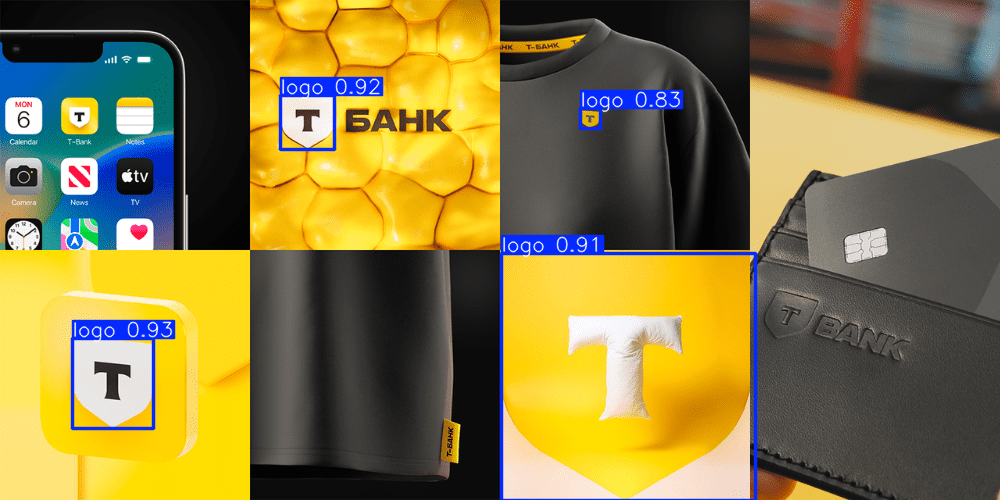

image 2/9 /kaggle/input/for-demonstration/demonstration/e7c677d8dc52__.png: 640x640 1 logo, 8.2ms

--- Detections in: /kaggle/input/for-demonstration/demonstration/e7c677d8dc52__.png ---
Detected T-Bank Logo with confidence: 0.32
Bounding Box Coordinates (xyxy): [86.10088348388672, 77.9366683959961, 314.26031494140625, 304.2419128417969]


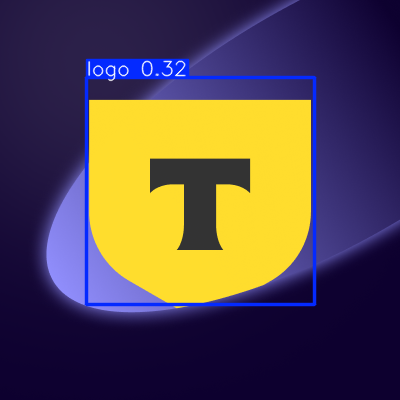

image 3/9 /kaggle/input/for-demonstration/demonstration/i.webp: 256x640 1 logo, 36.9ms

--- Detections in: /kaggle/input/for-demonstration/demonstration/i.webp ---
Detected T-Bank Logo with confidence: 0.91
Bounding Box Coordinates (xyxy): [62.16850280761719, 45.447174072265625, 169.5909423828125, 153.25491333007812]


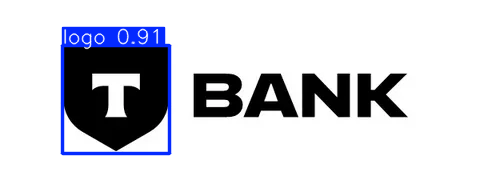

image 4/9 /kaggle/input/for-demonstration/demonstration/media_66a1238ec3ac2.png: 512x640 (no detections), 37.5ms

--- No detections in: /kaggle/input/for-demonstration/demonstration/media_66a1238ec3ac2.png ---
image 5/9 /kaggle/input/for-demonstration/demonstration/scale_1200-2.jpeg: 384x640 1 logo, 38.5ms

--- Detections in: /kaggle/input/for-demonstration/demonstration/scale_1200-2.jpeg ---
Detected T-Bank Logo with confidence: 0.91
Bounding Box Coordinates (xyxy): [453.8446044921875, 303.4876708984375, 530.2742919921875, 382.9631042480469]


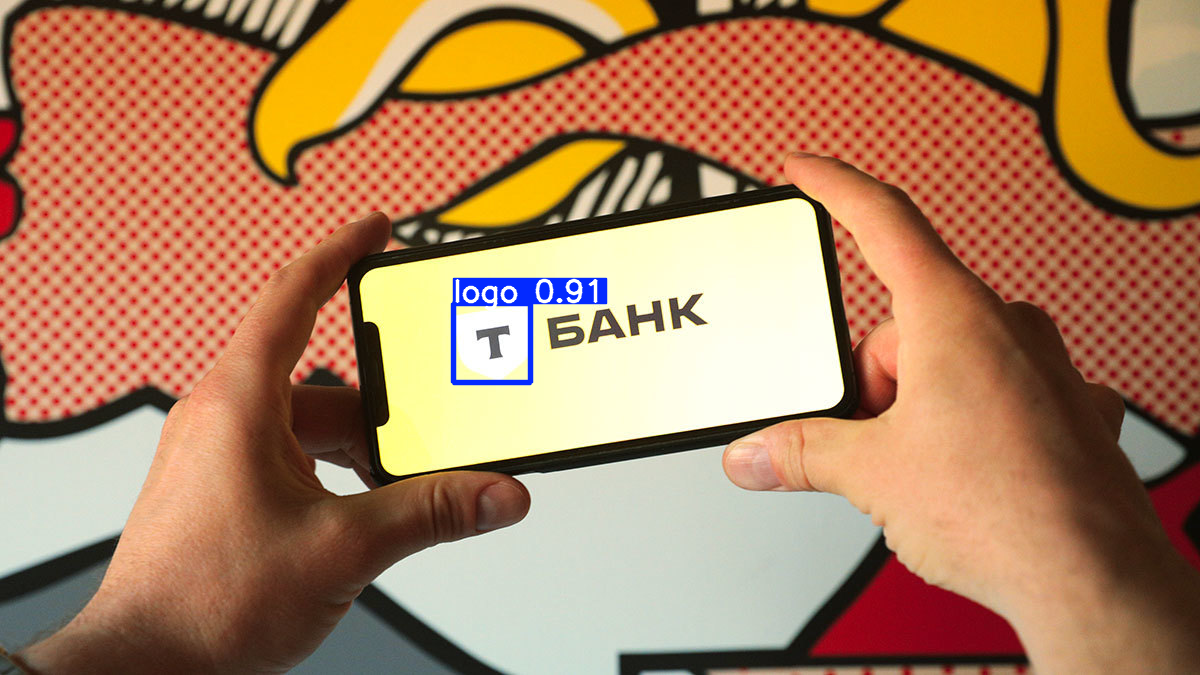

image 6/9 /kaggle/input/for-demonstration/demonstration/scale_1200-2.png: 416x640 3 logos, 36.8ms

--- Detections in: /kaggle/input/for-demonstration/demonstration/scale_1200-2.png ---
Detected T-Bank Logo with confidence: 0.90
Bounding Box Coordinates (xyxy): [130.9326171875, 368.64581298828125, 158.34390258789062, 398.6601257324219]
Detected T-Bank Logo with confidence: 0.86
Bounding Box Coordinates (xyxy): [56.747474670410156, 224.87156677246094, 83.10700988769531, 254.64437866210938]
Detected T-Bank Logo with confidence: 0.85
Bounding Box Coordinates (xyxy): [391.714599609375, 368.6709289550781, 418.2569274902344, 397.8111267089844]


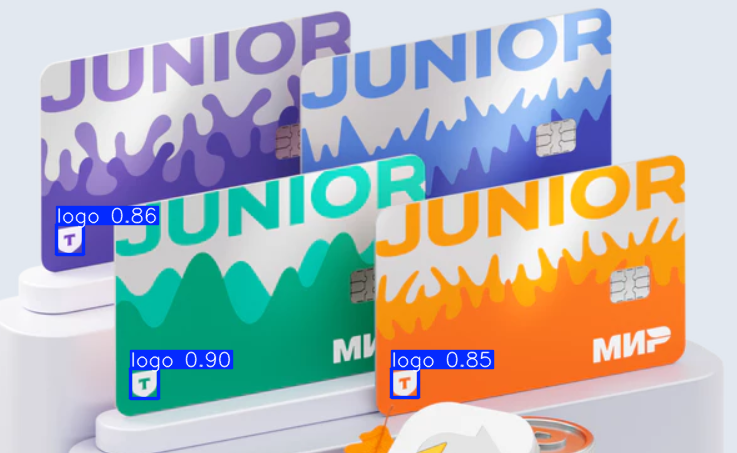

image 7/9 /kaggle/input/for-demonstration/demonstration/scale_1200-3.jpeg: 512x640 1 logo, 7.1ms

--- Detections in: /kaggle/input/for-demonstration/demonstration/scale_1200-3.jpeg ---
Detected T-Bank Logo with confidence: 0.55
Bounding Box Coordinates (xyxy): [134.5350799560547, 92.91842651367188, 464.9551696777344, 392.3482360839844]


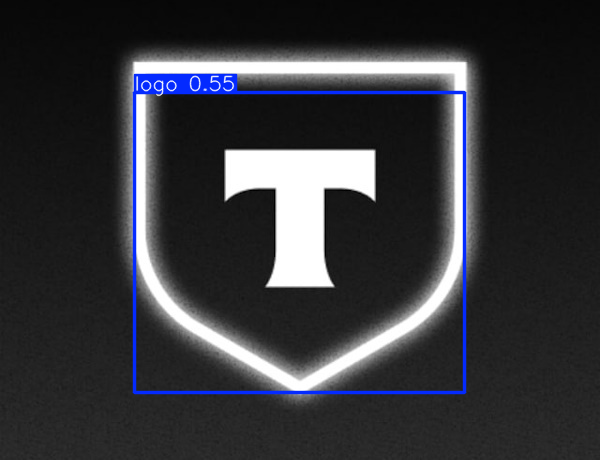

image 8/9 /kaggle/input/for-demonstration/demonstration/scale_1200.jpeg: 288x640 1 logo, 35.7ms

--- Detections in: /kaggle/input/for-demonstration/demonstration/scale_1200.jpeg ---
Detected T-Bank Logo with confidence: 0.70
Bounding Box Coordinates (xyxy): [408.2867126464844, 244.27304077148438, 452.8068542480469, 285.1394348144531]


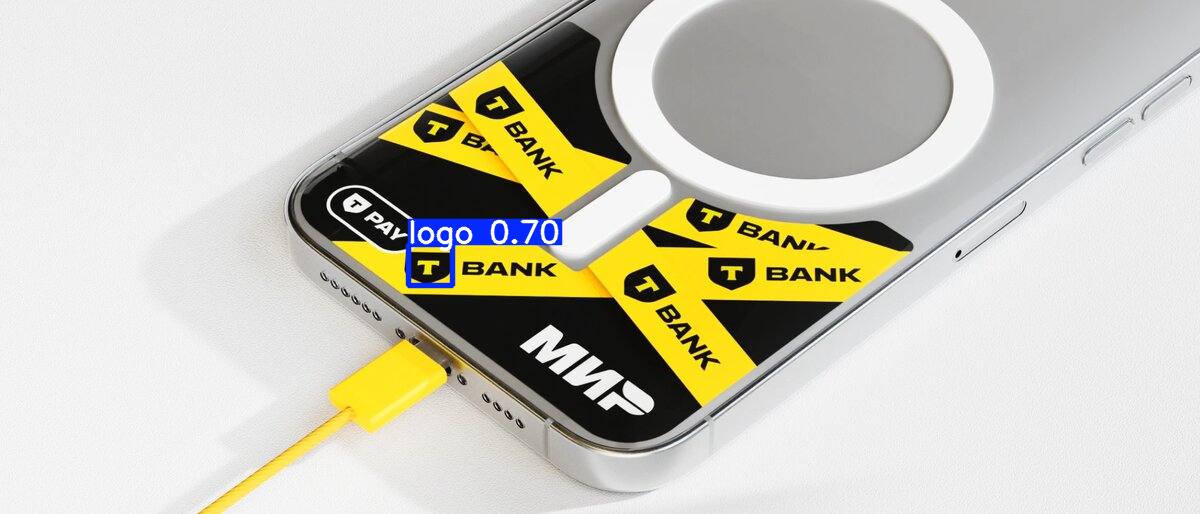

image 9/9 /kaggle/input/for-demonstration/demonstration/scale_1200.png: 288x640 1 logo, 6.7ms

--- Detections in: /kaggle/input/for-demonstration/demonstration/scale_1200.png ---
Detected T-Bank Logo with confidence: 0.93
Bounding Box Coordinates (xyxy): [679.1036987304688, 46.39835739135742, 715.2823486328125, 86.0414047241211]


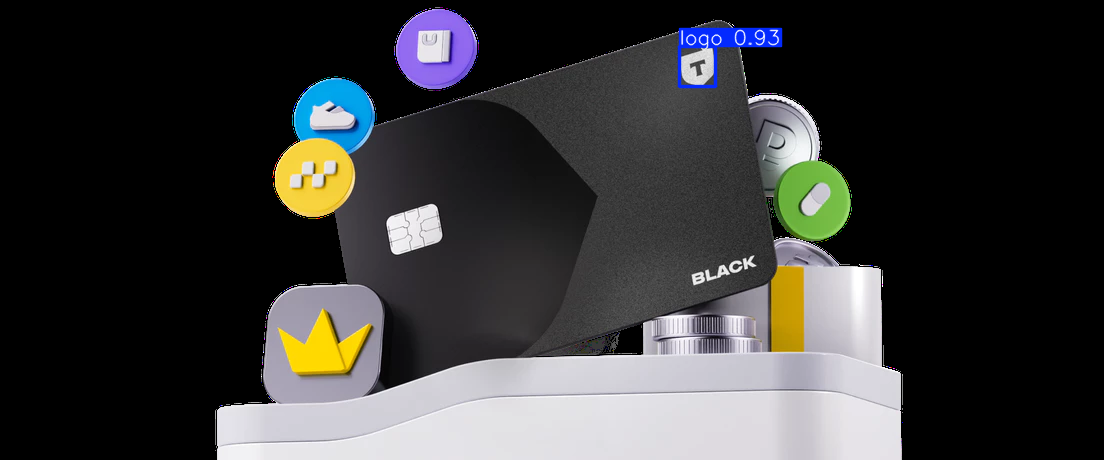

Speed: 2.2ms preprocess, 27.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


In [ ]:
import os
from google.colab.patches import cv2_imshow 

demonstrations_folder = '/kaggle/input/for-demonstration/demonstration'

if not os.path.isdir(demonstrations_folder):
    print(f"Error: The folder '{demonstrations_folder}' was not found.")
else:
    results = best_model.predict(source=demonstrations_folder, save=False, stream=True)
    for result in results:
        image_path = result.path
        
        if result.boxes.xyxy.numel() > 0:
            print(f"\n--- Detections in: {image_path} ---")
            for box in result.boxes:
                print(f"Detected T-Bank Logo with confidence: {box.conf.item():.2f}")
                print(f"Bounding Box Coordinates (xyxy): {box.xyxy.tolist()[0]}")
            annotated_image = result.plot()
            cv2_imshow(annotated_image)
        else:
            print(f"\n--- No detections in: {image_path} ---")

### **Визуальный анализ**

Несмотря на метрики (mAP50, mAP75), при визуальной оценке можно обнаружить некоторые сценарии, в которых модель может работать неидеально.

1.  **Маленькие логотипы:** На некоторых изображениях, где логотип занимает очень малую часть кадра, модель может его пропустить. Это связано с тем, что в процессе изменения размера изображения (до 640x640 пикселей) и в процессе работы свёрточных слоёв информация о мелких объектах может теряться.
2.  **Сильные искажения или окклюзии:** Хотя модель устойчива к поворотам, сильный наклон, искажение перспективы или перекрытие части логотипа могут привести к ошибке. Если часть логотипа закрыта другим объектом, модель может не определить его с высокой степенью уверенности.
3.  **Необычные цветовые решения:** Несмотря на то, что модель училась на логотипах разного цвета, необычные или экзотические цветовые схемы, которые не присутствовали в обучающей выборке, могут сбить её с толку.

## **Заключение**

### **Анализ ограничений решения**

Несмотря на выдающиеся метрики, модель имеет несколько ограничений, которые важно учитывать:
* **Детекция мелких объектов.** На изображениях, где логотип занимает очень малую часть кадра, его могут пропустить, поскольку информация о таких объектах может теряться в процессе изменения размера и обработки моделью.
* **Сильные искажения и окклюзии.** Модель может ошибиться, если логотип имеет сильные искажения, перекрыт другими объектами, либо расположен под необычным углом, не представленным в обучающей выборке.
* **Узкая специализация.** Модель была обучена на одном классе, что делает ее узкоспециализированной.

***

### **Сильные и слабые стороны решения**

* **Сильные стороны:**
    * **Производительность:** YOLOv8n — это самая быстрая и легкая модель в семействе YOLO. Она идеально подходит для REST API, где важна скорость.
    * **Точность:** Модель показала почти идеальные метрики (`mAP50-95` более 0.92), что свидетельствует о высоком качестве детекции.
    * **Эффективность:** Оптимальный баланс между скоростью и точностью.
    * **Простота использования:** Благодаря библиотеке Ultralytics, модель легко дообучать и интегрировать.

* **Слабые стороны:**
    * **Зависимость от данных:** Модель может работать хуже на данных, которые значительно отличаются от тех, что использовались для обучения, поэтому стоит хорошо порбаотать над тренировочном датасете, который по максимуму должен включать разнообразие логотипов с аугментациями.
    * **Ограниченная обобщаемость:** Модель заточена под один тип объекта.

***

### **Дополнительные альтернативы и улучшения**

1.  **Увеличение датасета.** Для повышения надежности можно было бы расширить датасет, добавив больше сложных примеров с сильными искажениями или очень мелкими логотипами.
2.  **Использование более мощных моделей.** Если бы скорость не была приоритетом, можно было бы рассмотреть более крупные модели, которые потенциально могли бы обеспечить еще более высокую точность, но за счет увеличения времени инференса.
3.  **Другие архитектуры.** В качестве альтернативы можно было бы рассмотреть двухэтапные детекторы, такие как **Faster R-CNN**, которые обычно более точны для мелких объектов, но значительно медленнее.